In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
dim = 30
population_size = 40
max_iterations = 100
alpha = 0.9
beta = 1 - alpha
elite_ratio = 0.2
max_stagnation = 15
mutation_rate = 0.05
w1, w2, d1, d2 = 0.75, 1, 40, 20

In [3]:
def evaluate(solution):
    # Simulated fitness: minimize number of 1s + noise
    return alpha * (sum(solution) / dim) + beta * random.uniform(0, 0.1)

# === Helper Functions ===
def crossover_uniform(parent1, parent2):
    return [(p1 if np.random.rand() > 0.5 else p2) for p1, p2 in zip(parent1, parent2)]

def crossover_two_point(parent1, parent2):
    a, b = sorted(random.sample(range(len(parent1)), 2))
    return parent1[:a] + parent2[a:b] + parent1[b:]

def mutate(solution, rate):
    return [bit if np.random.rand() > rate else 1 - bit for bit in solution]

def initialize_population():
    return [{'position': [random.randint(0, 1) for _ in range(dim)], 'fitness': None} for _ in range(population_size)]

In [5]:
def enhanced_fsro():
    pop = initialize_population()
    best_fitness_per_gen = []
    best_solution = None
    best_fitness = float('inf')
    stagnation_counter = 0

    for t in range(max_iterations):
        frogs = pop[:population_size // 2]
        snakes = pop[population_size // 2:]
        prev_fitness_f = [evaluate(f['position']) for f in frogs]
        prev_fitness_s = [evaluate(s['position']) for s in snakes]

        for agent in frogs:
            mate = random.choice(frogs)
            child = crossover_uniform(agent['position'], mate['position'])
            agent['position'] = mutate(child, mutation_rate)
            agent['fitness'] = evaluate(agent['position'])

        for agent in snakes:
            mate = random.choice(snakes)
            child = crossover_two_point(agent['position'], mate['position'])
            agent['position'] = mutate(child, mutation_rate)
            agent['fitness'] = evaluate(agent['position'])

        # Elite preservation
        elites = sorted(pop, key=lambda x: x['fitness'])[:int(elite_ratio * population_size)]

        # Replicator dynamics - adjust frog/snake sizes
        new_f, new_s = replicator_dynamics(frogs, snakes, prev_fitness_f, prev_fitness_s)
        frogs = random.choices(frogs, k=new_f)
        snakes = random.choices(snakes, k=new_s)

        pop = frogs + snakes + elites
        pop = sorted(pop, key=lambda x: x['fitness'])[:population_size]

        current_best = pop[0]
        best_fitness_per_gen.append(current_best['fitness'])

        if current_best['fitness'] < best_fitness:
            best_fitness = current_best['fitness']
            best_solution = current_best['position']
            stagnation_counter = 0
        else:
            stagnation_counter += 1

        # Dynamic reinitialization
        if stagnation_counter >= max_stagnation:
            for agent in random.sample(pop, k=int(0.3 * population_size)):
                agent['position'] = [random.randint(0, 1) for _ in range(dim)]
                agent['fitness'] = evaluate(agent['position'])
            stagnation_counter = 0

    return best_solution, best_fitness_per_gen

def replicator_dynamics(frogs, snakes, prev_frog_fit, prev_snake_fit):
    imp_f = sum([f['fitness'] - prev_frog_fit[i] for i, f in enumerate(frogs)])
    imp_s = sum([s['fitness'] - prev_snake_fit[i] for i, s in enumerate(snakes)])
    avg_f = imp_f / len(frogs) if frogs else 0
    avg_s = imp_s / len(snakes) if snakes else 0
    total = avg_f + avg_s
    if total == 0:
        return len(frogs), len(snakes)
    new_ratio_f = avg_f / total
    total_pop = len(frogs) + len(snakes)
    return max(2, int(new_ratio_f * total_pop)), max(2, total_pop - int(new_ratio_f * total_pop))


Best Fitness: 0.30436925957504707
Best Solution: [1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]


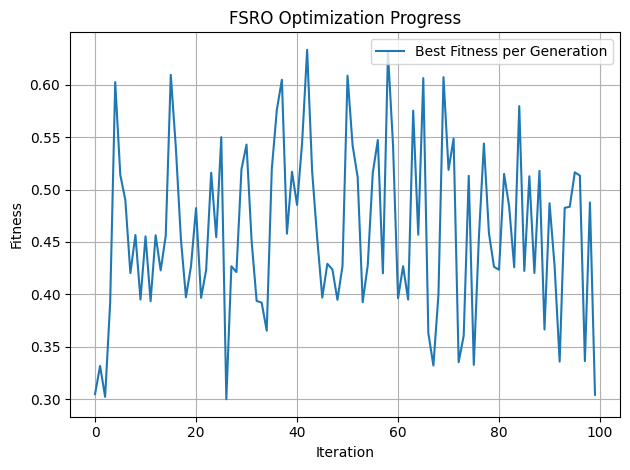

In [6]:
if __name__ == "__main__":
    solution, history = enhanced_fsro()
    print("Best Fitness:", history[-1])
    print("Best Solution:", solution)

    plt.plot(history, label="Best Fitness per Generation")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness")
    plt.title("FSRO Optimization Progress")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()